In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import os,sys
import json
import tensorflow as tf
from utils import *
from arguments import *

def get_tf_name(t_name) : 
    return t_name.split("/")[0]

def get_tf_numpy(t_name) :
    t = tf.get_collection(tf.GraphKeys.VARIABLES, t_name)[0]
    return t.eval()

def one_hot_encode_msa(msa, ns=21) :
    
    one_hot = np.zeros((a3m.shape[0], a3m.shape[1], ns))
    for i in range(a3m.shape[0]) :
        for j in range(a3m.shape[1]) :
            one_hot[i, j, int(msa[i, j])] = 1.
    
    return one_hot


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:

ckpt = "model2019_07/model.xaa"

n2d_layers   = 61
n2d_filters  = 64
window2d     = 3
wmin         = 0.8
ns           = 21

#
# network
#
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
)
activation = tf.nn.elu
conv1d = tf.layers.conv1d
conv2d = tf.layers.conv2d
with tf.Graph().as_default():

    with tf.name_scope('input'):
        ncol = tf.placeholder(dtype=tf.int32, shape=())
        nrow = tf.placeholder(dtype=tf.int32, shape=())
        msa = tf.placeholder(dtype=tf.uint8, shape=(None,None))
        is_train = tf.placeholder(tf.bool, name='is_train')
    
    #
    # collect features
    #
    msa1hot  = tf.one_hot(msa, ns, dtype=tf.float32)
    w = reweight(msa1hot, wmin)

    # 1D features
    f1d_seq = msa1hot[0,:,:20]
    f1d_pssm = msa2pssm(msa1hot, w)

    f1d = tf.concat(values=[f1d_seq, f1d_pssm], axis=1)
    f1d = tf.expand_dims(f1d, axis=0)
    f1d = tf.reshape(f1d, [1,ncol,42])

    # 2D features
    f2d_dca = tf.cond(nrow>1, lambda: fast_dca(msa1hot, w), lambda: tf.zeros([ncol,ncol,442], tf.float32))
    f2d_dca = tf.expand_dims(f2d_dca, axis=0)

    f2d = tf.concat([tf.tile(f1d[:,:,None,:], [1,1,ncol,1]), 
                    tf.tile(f1d[:,None,:,:], [1,ncol,1,1]),
                    f2d_dca], axis=-1)
    f2d = tf.reshape(f2d, [1,ncol,ncol,442+2*42])


    #
    # 2D network
    #
    layers2d = []
    layers2d_dict = {}
    
    layers2d_dict['f2d'] = f2d
    layers2d.append(layers2d_dict['f2d'])
    
    layers2d_dict['conv2d_0'] = conv2d(layers2d_dict['f2d'], n2d_filters, 1, padding='SAME')
    layers2d_dict['instancenorm_0'] = tf.contrib.layers.instance_norm(layers2d_dict['conv2d_0'])
    layers2d_dict['act_0'] = activation(layers2d_dict['instancenorm_0'])
    
    layers2d.append(layers2d_dict['conv2d_0'])
    layers2d.append(layers2d_dict['instancenorm_0'])
    layers2d.append(layers2d_dict['act_0'])
    
    # stack of residual blocks with dilations
    dilation = 1
    for i in range(n2d_layers):
        layers2d_dict['conv2d_' + str(i + 1)] = conv2d(layers2d[-1], n2d_filters, window2d, padding='SAME', dilation_rate=dilation)
        layers2d.append(layers2d_dict['conv2d_' + str(i + 1)])
        
        layers2d_dict['instancenorm_' + str(i + 1)] = tf.contrib.layers.instance_norm(layers2d[-1])
        layers2d.append(layers2d_dict['instancenorm_' + str(i + 1)])
        
        layers2d_dict['act_' + str(i + 1)] = activation(layers2d[-1])
        layers2d.append(layers2d_dict['act_' + str(i + 1)])
        
        layers2d_dict['drop_' + str(i + 1)] = tf.keras.layers.Dropout(rate=0.15)(layers2d[-1], training=is_train)
        layers2d.append(layers2d_dict['drop_' + str(i + 1)])
        
        layers2d_dict['conv2d2_' + str(i + 1)] = conv2d(layers2d[-1], n2d_filters, window2d, padding='SAME', dilation_rate=dilation)
        layers2d.append(layers2d_dict['conv2d2_' + str(i + 1)])
        
        layers2d_dict['instancenorm2_' + str(i + 1)] = tf.contrib.layers.instance_norm(layers2d[-1])
        layers2d.append(layers2d_dict['instancenorm2_' + str(i + 1)])
        
        layers2d_dict['act2_' + str(i + 1)] = activation(layers2d[-1] + layers2d[-7])
        layers2d.append(layers2d_dict['act2_' + str(i + 1)])
        
        #layers2d.append(conv2d(layers2d[-1], n2d_filters, window2d, padding='SAME', dilation_rate=dilation))
        #layers2d.append(tf.contrib.layers.instance_norm(layers2d[-1]))
        #layers2d.append(activation(layers2d[-1]))
        
        #layers2d.append(tf.keras.layers.Dropout(rate=0.15)(layers2d[-1], training=is_train))
        
        #layers2d.append(conv2d(layers2d[-1], n2d_filters, window2d, padding='SAME', dilation_rate=dilation))
        #layers2d.append(tf.contrib.layers.instance_norm(layers2d[-1]))
        #layers2d.append(activation(layers2d[-1] + layers2d[-7]))
        
        dilation *= 2
        if dilation > 16:
            dilation = 1

    # anglegrams for theta
    logits_theta = conv2d(layers2d[-1], 25, 1, padding='SAME')
    prob_theta = tf.nn.softmax(logits_theta)

    # anglegrams for phi
    logits_phi = conv2d(layers2d[-1], 13, 1, padding='SAME')
    prob_phi = tf.nn.softmax(logits_phi)

    # symmetrize
    layers2d.append(0.5 * (layers2d[-1] + tf.transpose(layers2d[-1], perm=[0,2,1,3])))

    # distograms
    logits_dist = conv2d(layers2d[-1], 37, 1, padding='SAME')
    prob_dist = tf.nn.softmax(logits_dist)

    # beta-strand pairings (not used)
    logits_bb = conv2d(layers2d[-1], 3, 1, padding='SAME')
    prob_bb = tf.nn.softmax(logits_bb)

    # anglegrams for omega
    logits_omega = conv2d(layers2d[-1], 25, 1, padding='SAME')
    prob_omega = tf.nn.softmax(logits_omega)

    saver = tf.train.Saver()

    with tf.Session(config=config) as sess:
        saver.restore(sess, ckpt)
        
        #Create Keras model below
        
        print("Initializing Keras Model.")
        
        #Specify Keras inputs
        f1d_seq_keras = Input(shape=(None, 20))
        msa1hot_keras = Input(shape=(None, None, 21))

        def keras_collect_features(inputs) :
            f1d_seq_batched, msa1hot_batched = inputs

            f1d_seq = f1d_seq_batched[0, ...]
            msa1hot = msa1hot_batched[0, ...]

            nrow = K.shape(msa1hot)[0]
            ncol = K.shape(msa1hot)[1]

            w = reweight(msa1hot, wmin)

            # 1D features
            f1d_pssm = msa2pssm(msa1hot, w)

            f1d = tf.concat(values=[f1d_seq, f1d_pssm], axis=1)
            f1d = tf.expand_dims(f1d, axis=0)
            f1d = tf.reshape(f1d, [1,ncol,42])

            # 2D features
            f2d_dca = tf.cond(nrow>1, lambda: fast_dca(msa1hot, w), lambda: tf.zeros([ncol,ncol,442], tf.float32))
            f2d_dca = tf.expand_dims(f2d_dca, axis=0)

            f2d = tf.concat([tf.tile(f1d[:,:,None,:], [1,1,ncol,1]), 
                            tf.tile(f1d[:,None,:,:], [1,ncol,1,1]),
                            f2d_dca], axis=-1)
            f2d = tf.reshape(f2d, [1,ncol,ncol,442+2*42])

            return f2d

        #Collect Keras features
        f2d_keras = Lambda(keras_collect_features)([f1d_seq_keras, msa1hot_keras])
        
        #Specify Keras initial tensor
        conv2d_0_keras = Conv2D(n2d_filters, (1, 1), padding='same', activation='linear', name='rosetta_conv2d_0')
        instancenorm_0_keras = InstanceNormalization(axis=-1, epsilon=1e-06, name='rosetta_instancenorm_0')
        act_0_keras = Lambda(lambda x: K.elu(x))

        out_tensor_keras = act_0_keras(instancenorm_0_keras(conv2d_0_keras(f2d_keras)))

        # stack of residual blocks with dilations
        dilation = 1
        for i in range(n2d_layers) :
            
            print("Initializing ResBlock " + str(i) + ".")
            
            #Specify Keras residual block
            conv2d_res_0_keras = Conv2D(n2d_filters, window2d, padding='same', activation='linear', dilation_rate=dilation, name='rosetta_conv2d_' + str(i + 1))
            instancenorm_res_0_keras = InstanceNormalization(axis=-1, epsilon=1e-06, name='rosetta_instancenorm_' + str(i + 1))
            act_res_0_keras = Lambda(lambda x: K.elu(x))

            drop_res_0_keras = Dropout(0.15)

            conv2d_res_1_keras = Conv2D(n2d_filters, window2d, padding='same', activation='linear', dilation_rate=dilation, name='rosetta_conv2d2_' + str(i + 1))
            instancenorm_res_1_keras = InstanceNormalization(axis=-1, epsilon=1e-06, name='rosetta_instancenorm2_' + str(i + 1))
            add_res_1_keras = Lambda(lambda x: x[0] + x[1])
            act_res_1_keras = Lambda(lambda x: K.elu(x))

            act_res_0_keras_out = act_res_0_keras(instancenorm_res_0_keras(conv2d_res_0_keras(out_tensor_keras)))
            drop_res_0_keras_out = drop_res_0_keras(act_res_0_keras_out)
            act_res_1_keras_out = act_res_1_keras(add_res_1_keras([instancenorm_res_1_keras(conv2d_res_1_keras(drop_res_0_keras_out)), out_tensor_keras]))

            out_tensor_keras = act_res_1_keras_out

            dilation *= 2
            if dilation > 16:
                dilation = 1

        #Specify Keras outputs
        logits_theta_keras = Conv2D(25, (1, 1), padding='same', activation='linear', name='rosetta_logits_theta')
        probs_theta_keras = Softmax(axis=-1)

        logits_phi_keras = Conv2D(13, (1, 1), padding='same', activation='linear', name='rosetta_logits_phi')
        probs_phi_keras = Softmax(axis=-1)

        symmetrize_keras = Lambda(lambda x: 0.5 * (x + tf.transpose(x, perm=[0,2,1,3])))

        logits_dist_keras = Conv2D(37, (1, 1), padding='same', activation='linear', name='rosetta_logits_dist')
        probs_dist_keras = Softmax(axis=-1)

        logits_omega_keras = Conv2D(25, (1, 1), padding='same', activation='linear', name='rosetta_logits_omega')
        probs_omega_keras = Softmax(axis=-1)

        
        probs_theta_keras_out = probs_theta_keras(logits_theta_keras(out_tensor_keras))
        probs_phi_keras_out = probs_phi_keras(logits_phi_keras(out_tensor_keras))

        symmetric_out_tensor_keras = symmetrize_keras(out_tensor_keras)

        probs_dist_keras_out = probs_dist_keras(logits_dist_keras(symmetric_out_tensor_keras))
        probs_omega_keras_out = probs_omega_keras(logits_omega_keras(symmetric_out_tensor_keras))

        #Instantiate Keras model

        predictor_keras = Model(
            inputs = [
                f1d_seq_keras, msa1hot_keras
            ],
            outputs = [
                probs_dist_keras_out, probs_theta_keras_out, probs_phi_keras_out, probs_omega_keras_out
            ]
        )
        
        print("Setting Weights.")
        
        #Set Keras weights
        predictor_keras.get_layer("rosetta_conv2d_0").set_weights([
            get_tf_numpy(get_tf_name(layers2d_dict['conv2d_0'].name) + "/kernel"),
            get_tf_numpy(get_tf_name(layers2d_dict['conv2d_0'].name) + "/bias")
        ])
        
        #Set Keras weights
        predictor_keras.get_layer("rosetta_instancenorm_0").set_weights([
            get_tf_numpy(get_tf_name(layers2d_dict['instancenorm_0'].name) + "/gamma"),
            get_tf_numpy(get_tf_name(layers2d_dict['instancenorm_0'].name) + "/beta")
        ])
        
        
        for i in range(n2d_layers) :
            
            print("Setting Weights for ResBlock " + str(i) + ".")
            
            predictor_keras.get_layer('rosetta_conv2d_' + str(i + 1)).set_weights([
                get_tf_numpy(get_tf_name(layers2d_dict['conv2d_' + str(i + 1)].name) + "/kernel"),
                get_tf_numpy(get_tf_name(layers2d_dict['conv2d_' + str(i + 1)].name) + "/bias")
            ])
            
            predictor_keras.get_layer('rosetta_instancenorm_' + str(i + 1)).set_weights([
                get_tf_numpy(get_tf_name(layers2d_dict['instancenorm_' + str(i + 1)].name) + "/gamma"),
                get_tf_numpy(get_tf_name(layers2d_dict['instancenorm_' + str(i + 1)].name) + "/beta")
            ])
            
            predictor_keras.get_layer('rosetta_conv2d2_' + str(i + 1)).set_weights([
                get_tf_numpy(get_tf_name(layers2d_dict['conv2d2_' + str(i + 1)].name) + "/kernel"),
                get_tf_numpy(get_tf_name(layers2d_dict['conv2d2_' + str(i + 1)].name) + "/bias")
            ])
            
            predictor_keras.get_layer('rosetta_instancenorm2_' + str(i + 1)).set_weights([
                get_tf_numpy(get_tf_name(layers2d_dict['instancenorm2_' + str(i + 1)].name) + "/gamma"),
                get_tf_numpy(get_tf_name(layers2d_dict['instancenorm2_' + str(i + 1)].name) + "/beta")
            ])
        
        
        predictor_keras.get_layer("rosetta_logits_theta").set_weights([
            get_tf_numpy(get_tf_name(logits_theta.name) + "/kernel"),
            get_tf_numpy(get_tf_name(logits_theta.name) + "/bias")
        ])
        
        predictor_keras.get_layer("rosetta_logits_phi").set_weights([
            get_tf_numpy(get_tf_name(logits_phi.name) + "/kernel"),
            get_tf_numpy(get_tf_name(logits_phi.name) + "/bias")
        ])
        
        predictor_keras.get_layer("rosetta_logits_dist").set_weights([
            get_tf_numpy(get_tf_name(logits_dist.name) + "/kernel"),
            get_tf_numpy(get_tf_name(logits_dist.name) + "/bias")
        ])
        
        predictor_keras.get_layer("rosetta_logits_omega").set_weights([
            get_tf_numpy(get_tf_name(logits_omega.name) + "/kernel"),
            get_tf_numpy(get_tf_name(logits_omega.name) + "/bias")
        ])
        
        print("Compiling and Saving.")
        
        predictor_keras.compile(optimizer=keras.optimizers.SGD(0.1), loss='mse')
        predictor_keras.save(os.path.join(os.getcwd(), ckpt + ".h5"))



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Initializing Keras Model.
Initializing ResBlock 0.
Initializing ResBlock 1.
Initializing ResBlock 2.
Initializing ResBlock 3.
Initializing ResBlock 4.
Initializing ResBlock 5.
Initializing ResBlock 6.
Initializing ResBlock 7.
Initializing ResBlock 8.
Initializing ResBlock 9.
Initializing ResBlock 10.
Initializing ResBlock 11.
Initializing ResBlock 12.
Initializing ResBlock 13.
Initializing ResBlock 14.
Initializing ResBlock 15.
Initializing ResBlock 16.
Initializing ResBlock 17.
Initializing ResBlock 18.
Initializing ResBlock 19.
Initializing ResBlock 20.
Initializing ResBlock 21.
Initializing ResBlock 22.
Initializing ResBlock 23.
Initializing ResBlock 24.
Initializing ResBlock 25.
Initializing ResBlock 26.
Initializing ResBlock 27.
Initializing ResBloc

In [3]:

K.clear_session()

ckpt = "model2019_07/model.xaa"

predictor_keras = load_model(ckpt + ".h5", custom_objects = {
    'InstanceNormalization' : InstanceNormalization,
    'reweight' : reweight,
    'wmin' : 0.8,
    'msa2pssm' : msa2pssm,
    'tf' : tf,
    'fast_dca' : fast_dca
})


In [23]:

msa_file = "../example/T1001.a3m"

a3m = parse_a3m(msa_file)

msa_one_hot = np.expand_dims(one_hot_encode_msa(a3m), axis=0)

pd, pt, pp, po = predictor_keras.predict(x=[msa_one_hot[:, 0, :, :20], msa_one_hot], batch_size=1)
#pd, pt, pp, po = predictor_keras.predict(x=[msa_one_hot[:, 0, :, :20], msa_one_hot[:, :1, :]], batch_size=1)


In [24]:

npz_file = "../example/T1001_keras_xaa.npz"

np.savez_compressed(npz_file, dist=pd, omega=pt, theta=pp, phi=po)


In [8]:

npz_file_keras = "../example/T1001_keras_xaa.npz"
npz_file_tf = "../example/T1001_tf_xaa.npz"

data_keras = np.load(npz_file_keras)
data_tf = np.load(npz_file_tf)

pd_keras, pt_keras, pp_keras, po_keras = data_keras['dist'], data_keras['omega'], data_keras['theta'], data_keras['phi']
pd_tf, pt_tf, pp_tf, po_tf = data_tf['dist'], data_tf['omega'], data_tf['theta'], data_tf['phi']


Comparison of distance.


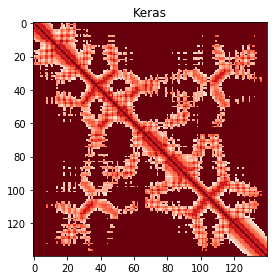

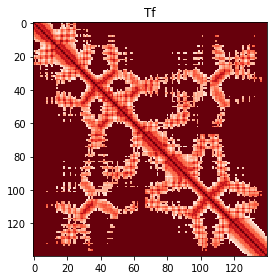

Comparison of theta.


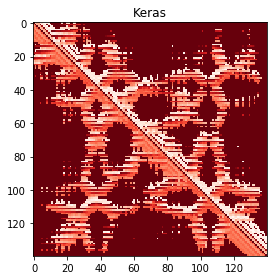

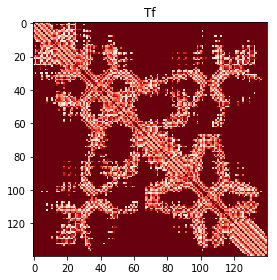

Comparison of phi.


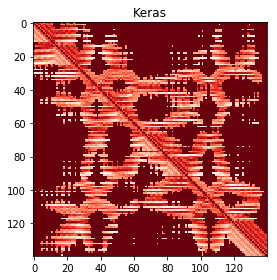

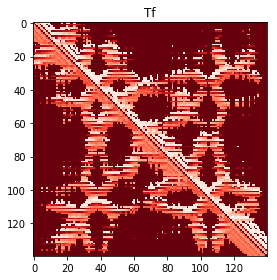

Comparison of omega.


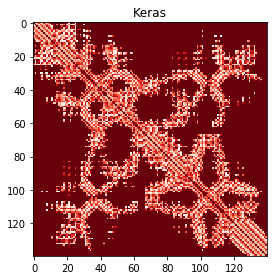

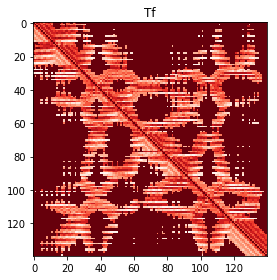

In [9]:

keras_tf_list = [
    [pd_keras, pd_tf, 'distance'],
    [pt_keras, pt_tf, 'theta'],
    [pp_keras, pp_tf, 'phi'],
    [po_keras, po_tf, 'omega']
]

for p_keras, p_tf, p_name in keras_tf_list :

    print("Comparison of " + p_name + ".")
    
    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)
    p_tf_vals = np.argmax(p_tf, axis=-1)

    f = plt.figure(figsize=(4, 4))

    plt.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    plt.title("Keras")

    plt.tight_layout()
    plt.show()

    f = plt.figure(figsize=(4, 4))

    plt.imshow(np.max(p_tf_vals) - p_tf_vals, cmap="Reds", vmin=0, vmax=np.max(p_tf_vals))

    plt.title("Tf")

    plt.tight_layout()
    plt.show()


In [10]:
#Test equalities (Less than 1% different after rounding)

print(len(np.nonzero(np.ravel(np.round(pd_keras[0, ...], 3) != np.round(pd_tf, 3)))[0]) < 0.01 * (pd_tf.shape[0] * pd_tf.shape[1] * pd_tf.shape[2]))
print(len(np.nonzero(np.ravel(np.round(pt_keras[0, ...], 1) != np.round(pt_tf, 1)))[0]) < 0.25 * (pt_tf.shape[0] * pt_tf.shape[1] * pt_tf.shape[2]))
print(len(np.nonzero(np.ravel(np.round(pp_keras[0, ...], 3) != np.round(pp_tf, 3)))[0]) < 0.01 * (pp_tf.shape[0] * pp_tf.shape[1] * pp_tf.shape[2]))
print(len(np.nonzero(np.ravel(np.round(po_keras[0, ...], 3) != np.round(po_tf, 3)))[0]) < 0.01 * (po_tf.shape[0] * po_tf.shape[1] * po_tf.shape[2]))


True
True
True
True


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
